Работу выполнил Данил Исламов (Stepik ID: 274397404)

<img src="https://static.wixstatic.com/media/66c28f_db7a1ba3e35b4b17a6688472c889b7bf~mv2_d_2777_1254_s_2.png/v1/fill/w_710,h_320,al_c,q_85,usm_0.66_1.00_0.01/logo_yellow_white.webp" width=1000, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

# Text Summarization

Всем привет! Сегодня мы познакомимся с задачей суммаризации текста на примере генерации "сжатых" новостей. Рассмотрим некоторые базовые решения и познакомимся с архитектурами нейросетей для решения задачи.
Датасет: gazeta.ru


`Ноутбук создан на основе семинара Гусева Ильи на кафедре компьютерной лингвистики ABBYY МФТИ.`

Загрузим датасет и необходимые библиотеки

In [ ]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [ ]:
!pip -q install razdel networkx pymorphy2 nltk rouge==0.3.1 summa 

     |████████████████████████████████| 61kB 2.7MB/s 
     |████████████████████████████████| 61kB 4.7MB/s 
     |████████████████████████████████| 8.2MB 1.6MB/s 


In [ ]:
!pip install youtokentome

     |████████████████████████████████| 1.7MB 4.8MB/s 


In [ ]:
import json
import random
import razdel
from tqdm.notebook import tqdm
import copy
import torch
import math
import numpy as np
import pandas as pd

from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
import youtokentome as yttm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Dataset

Посмотрим на то, как устроен датасет

In [ ]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [ ]:
def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date, "Either shuffle or sorting should be chosen"
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle(records)
    return records

In [ ]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [ ]:
def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

## Extractive RNN

### BPE
Для начала сделаем BPE токенизацию

In [ ]:
def train_bpe(records, model_path, model_type="bpe", vocab_size=10000, lower=True):
    temp_file_name = "temp.txt"
    with open(temp_file_name, "w") as temp:
        for record in records:
            text, summary = record['text'], record['summary']
            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue
            temp.write(text + "\n")
            temp.write(summary + "\n")
    yttm.BPE.train(data=temp_file_name, vocab_size=vocab_size, model=model_path)

train_bpe(train_records, "BPE_model.bin")

### Словарь
Составим словарь для индексации токенов

In [ ]:
bpe_processor = yttm.BPE('BPE_model.bin')
vocabulary = bpe_processor.vocab()

### Кэш oracle summary
Закэшируем oracle summary, чтобы не пересчитывать их каждый раз

In [ ]:
def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложение к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries, key=lambda x: x[0])
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break
        text = record["text"]
        summary = record["summary"]

        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indices = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        record["sentences"] = sentences
        record["oracle_sentences"] = list(sentences_indices)
        record["oracle_summary"] = oracle_summary

    return records[:nrows]

ext_train_records = add_oracle_summary_to_records(train_records, nrows=2048)
ext_val_records = add_oracle_summary_to_records(val_records, nrows=256)
ext_test_records = add_oracle_summary_to_records(test_records, nrows=256)

### Составление батчей

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class BatchIterator():
    def __init__(self, records, vocabulary, batch_size, bpe_processor, shuffle=True, 
                 lower=True, max_sentences=30, max_sentence_length=50, device=torch.device('cpu')):
        
        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device
        
    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []

            for data_ind in batch_indices:
                
                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [sentence.text.lower() if self.lower else sentence.text 
                                 for sentence in razdel.sentenize(text)][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)
                
                # номера предложений, которые попали в наше summary
                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    sentences_indices = build_oracle_summary_greedy(text, summary, 
                                                                     calc_score=calc_score, lower=self.lower, 
                                                                     max_sentences=self.max_sentences)[1]
                else:   
                    sentences_indices = record["oracle_sentences"]
                
                # inputs - индексы слов в предложении
                inputs = [bpe_processor.encode(sentence)[:self.max_sentence_length] for sentence in sentences]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))
                
                # получение метки класса предложения
                outputs = [int(i in sentences_indices) for i in range(len(sentences))]
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)

            tensor_inputs = torch.zeros((self.batch_size, max_sentences, max_sentence_length), dtype=torch.long, device=self.device)
            # we add index 2 for padding
            tensor_outputs = 2 * torch.ones((self.batch_size, max_sentences), dtype=torch.float32, device=self.device)

            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.tensor(sentence_tokens, dtype=torch.int64)

            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)

            tensor_outputs = tensor_outputs.long()
            yield {
                'inputs': tensor_inputs,
                'outputs': tensor_outputs,
                'records': batch_records
            }

In [ ]:
train_iterator = BatchIterator(ext_train_records, vocabulary, 32, bpe_processor, device=device)
val_iterator = BatchIterator(ext_val_records, vocabulary, 32, bpe_processor, device=device)
test_iterator = BatchIterator(ext_test_records, vocabulary, 32, bpe_processor, device=device)

## Extractor -  SummaRuNNer
 https://arxiv.org/pdf/1611.04230.pdf


### Homework

* В данной реализации в `outputs` в качестве padding используется индекс 0. Измените в функции \_\_iter__ индекс padding так, чтобы он не совпадал с классом (0 или 1) — например, 2.
* В качестве criterion используйте `CrossEntropyLoss` вместо `BCEWithLogitsLoss`
* Из-за смены criterion, вы уже должны подавать на вход criterion не одно число, а logits для каждого класса. Перед подачей logits вы можете отфильтровать предсказания для класса padding. В этом пункте вам придется изменять файл `train_model.py`, а именно функции `train` и `evaluate`.
* Используйте два варианта обучения: c весами в `CrossEntropyLoss` и без
* Также сравните `inference`, когда вы ранжируете logits и когда вы выбирате предложения, у которых logits > 0, в двух вариантах обучения. 
* Реализуйте дополнительно характеристику предложения `novelty`. Как влияет добавление `novelty` на качество summary?
* Постарайтесь улучшить качество модели, полученной на семинаре: $BLEU \approx 0.45$

In [ ]:
class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        # inputs = [batch_size * seq_num, seq_len]
        embedded = self.dropout_layer(self.embedding_layer(inputs))
        outputs, _ = self.rnn_layer(embedded, hidden)
        # [batch_size * seq_num, seq_len, hidden_size]
        sentences_embeddings = torch.mean(outputs, 1)
        # [batch_size * seq_num, hidden_size]
        return sentences_embeddings

class SentenceTaggerRNN(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 use_novelty=True,
                 token_embedding_dim=128,
                 sentence_encoder_hidden_size=256,
                 hidden_size=256,
                 bidirectional=True,
                 sentence_encoder_n_layers=3,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers=3,
                 dropout=0.3):
        
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers, 
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)
        
        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)
        
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * num_directions, 1)
        self.document_linear_layer = nn.Linear(hidden_size * num_directions, hidden_size * num_directions)
        self.salience_linear_layer = nn.Linear(hidden_size * num_directions, hidden_size * num_directions)
        self.novelty_linear_layer = nn.Linear(hidden_size * num_directions, hidden_size * num_directions)
        self.doc_tanh_layer = nn.Tanh()
        self.nov_tanh_layer = nn.Tanh()

        self.use_novelty = use_novelty

    def forward(self, inputs, hidden=None):
        
        # inputs = [batch_size, seq_num, seq_len]
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count)
        # [batch_size * seq_num, seq_len]
        
        # parameters of the probability
        content = torch.zeros((batch_size, sentences_count, 2), device=device)
        salience = torch.zeros((batch_size, sentences_count, 2), device=device)
        
        embedded_sentences = self.sentence_encoder(inputs)
        # [batch_size *  seq_num, hidden_size]
        embedded_sentences = self.dropout_layer(embedded_sentences.reshape(
                             (batch_size, sentences_count, embedded_sentences.size(1))))
        # [batch_size, seq_num, hidden_size]

        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        # [batch_size, seq_num, hidden_size]

        document_embedding = self.doc_tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        # [batch_size, seq_num, hidden_size] * [hidden_size, hidden_size] = [batch_size, seq_num, hidden_size]
        # [batch_size, seq_num, hidden_size] -> [batch_size, hidden_size]

        # W * h
        content[:, :, 1] = self.content_linear_layer(outputs).squeeze(2)
        # [batch_size, seq_num, hidden_size] * [hidden_size, 1] = [batch_size, seq_num, 1]
        # [batch_size, seq_num, 1] -> [batch_size, seq_num]

        # h^T * W * d
        salience[:, :, 1] = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2)
        # [batch_size, hidden_size] * [hidden_size, hidden_size] = [batch_size, hidden_size]
        # [batch_size, hidden_size] -> [batch_size, hidden_size, 1]
        # [batch_size, seq num, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, seq num, 1]
        # [batch_size, seq num, 1] -> [batch_size, seq num]

        predictions = content + salience
        # [batch_size, seq_num, 2]
        
        if self.use_novelty:
            # at every step add novelty to prediction of the sentence 
            
            # 0) initialize summary_representation and novelty by zeros
            # summary_representation: [batch_size, seq_num, hidden_size]
            # novelty: [batch_size, seq_num, 2]
            summary_representation = torch.zeros((batch_size, sentences_count, self.hidden_size * (1+self.bidirectional)), device=device)
            novelty = torch.zeros((batch_size, sentences_count, 2), device=device)

            # for 1st (with index 0) sentence prob is calculated without novelty;
            # then novelty should be calculated dynamically according to the obtained probs
            # sent representations are stored in outputs
            # as the algorithm is the same for every i-th sentence of every text, we can work with [batch_size, i] arrays
            for sentence_num in range(sentences_count):

                # 1) take (sentence_num)'th state from outputs(representation of the sentence with number sentence_num)
                # 2) calculate novelty for current sentence
                # 3) add novelty to predictions
                # 4) calculcate probability for current sentence
                # 5) add (sentence_num)'th state with the weight=probability to current summary_representation
                
                novelty[:, sentence_num:sentence_num+1, 1] = torch.bmm(outputs[:, sentence_num:sentence_num+1, :], 
                                                     self.novelty_linear_layer(
                                                         self.nov_tanh_layer(summary_representation[:, sentence_num, :])
                                                         ).unsqueeze(2)).squeeze(2)
                # [batch_size, hidden_size] * [hidden_size, hidden_size] = [batch_size, hidden_size]
                # [batch_size, hidden_size] -> [batch_size, hidden_size, 1]
                # [batch_size, 1, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, 1, 1]
                # [batch_size, 1, 1] -> [batch_size, 1]
                
                if sentence_num != sentences_count - 1:
                    summary_representation[:, sentence_num+1:sentence_num+2] = torch.bmm(predictions[:, :sentence_num+1, 1].unsqueeze(1), 
                                                                          outputs[:, :sentence_num+1, :])
                    # [batch_size, cur_seq_num] -> [batch_size, 1, cur_seq_num]
                    # [batch_size, 1, cur_seq_num] * [batch_size, cur_seq_num, hidden_size] = [batch_size, 1, hidden_size]
                
                predictions = content + salience - novelty

        predictions[:, :, 0] = - predictions[:, :, 1]   
        
        return predictions

## Model


Здесь и далее буду обозначать модели "model_ij", где i, j — булевы переменные; i показывает, используется ли novelty, j показывает, используются ли веса в кросс-энтропии. 

Начнём с тренировки и инференса модели model_11 — т.е. с использованием novelty и весов.

In [ ]:
vocab_size = len(vocabulary)
model_11 = SentenceTaggerRNN(vocab_size).to(device)

params_count = np.sum([p.numel() for p in model_11.parameters() if p.requires_grad])
print("Trainable params: {}".format(params_count))

Trainable params: 3718145


In [ ]:
for name, param in model_11.named_parameters():
    print(f"{name}: {param.numel()}")

sentence_encoder.embedding_layer.weight: 1280000
sentence_encoder.rnn_layer.weight_ih_l0: 65536
sentence_encoder.rnn_layer.weight_hh_l0: 65536
sentence_encoder.rnn_layer.bias_ih_l0: 512
sentence_encoder.rnn_layer.bias_hh_l0: 512
sentence_encoder.rnn_layer.weight_ih_l0_reverse: 65536
sentence_encoder.rnn_layer.weight_hh_l0_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l0_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l0_reverse: 512
sentence_encoder.rnn_layer.weight_ih_l1: 131072
sentence_encoder.rnn_layer.weight_hh_l1: 65536
sentence_encoder.rnn_layer.bias_ih_l1: 512
sentence_encoder.rnn_layer.bias_hh_l1: 512
sentence_encoder.rnn_layer.weight_ih_l1_reverse: 131072
sentence_encoder.rnn_layer.weight_hh_l1_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l1_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l1_reverse: 512
sentence_encoder.rnn_layer.weight_ih_l2: 131072
sentence_encoder.rnn_layer.weight_hh_l2: 65536
sentence_encoder.rnn_layer.bias_ih_l2: 512
sentence_encoder.rnn_layer.

In [ ]:
!gdown https://drive.google.com/uc?id=1p04Gp_NQ8Mp7L_1JMAWbtzOYAVwijyPD -O train_model.py
import train_model
import imp 
imp.reload(train_model)
from train_model import train_with_logs

Downloading...
From: https://drive.google.com/uc?id=1p04Gp_NQ8Mp7L_1JMAWbtzOYAVwijyPD
To: /content/train_model.py
100% 4.79k/4.79k [00:00<00:00, 7.53MB/s]


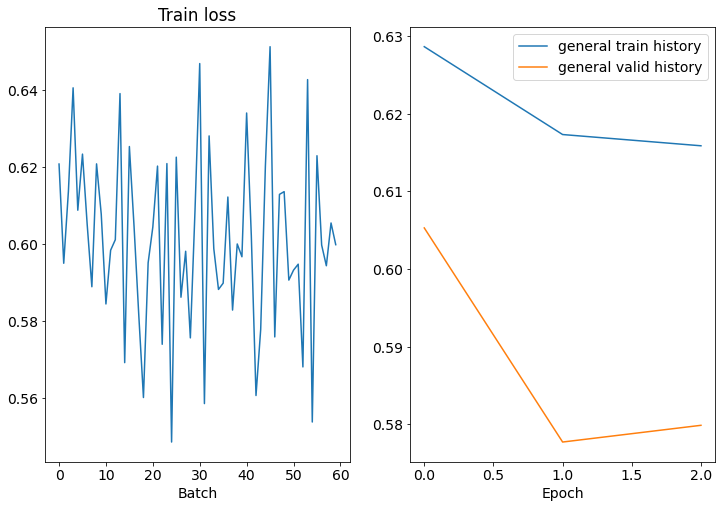

Epoch: 04 | Time: 0m 17s
	Train Loss: 0.602 | Train PPL:   1.826
	 Val. Loss: 0.587 |  Val. PPL:   1.799


In [ ]:
N_EPOCHS = 4
CLIP = 1

def general_train(model, use_class_weights, N_EPOCHS, CLIP, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr)
    if use_class_weights:
        # weights depend on the number of objects of class 0 and 1
        weight0 = sum([sum(batch['outputs'].view(-1) == 1) / 
                       (len(train_iterator) * batch['outputs'].size(0) * batch['outputs'].size(1)) 
                       for batch in train_iterator])
        
        weights = torch.tensor([weight0, 1-weight0]).to(device)
        criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=2)
    else:
        criterion = nn.CrossEntropyLoss(ignore_index=2)
    train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

general_train(model_11, True, N_EPOCHS, CLIP)

## Inference

In [ ]:
from train_model import punct_detokenize, postprocess

def inference_summarunner(model, iterator, top_k=3):

    references = []
    predictions = []

    model.eval()
    for batch in test_iterator:
        # get prob of class 1 for every sent
        logits = model(batch['inputs'])[:, :, 1]
        # [batch_size, seq_num]

        # sort sents by probs and get top-k with highest probs
        sum_in = torch.argsort(logits, dim=1)[:, -top_k:]
        # [batch_size, top_k]

        for i in range(len(batch['outputs'])):

            summary = batch['records'][i]['summary'].lower()
            pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in.sort(dim=1)[0][i]
                                     if ind < len(batch['records'][i]['sentences'])])
            if pred_summary == '':
                pred_summary = '_'
            
            summary, pred_summary = postprocess(summary, pred_summary)

            references.append(summary)
            predictions.append(pred_summary)

    calc_scores(references, predictions)

model_11.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model_11, test_iterator, 3)

Count: 256
Ref: открыта регистрация на новый конкурс « лидеры россии . политика » , направленный на выявление общественно-политических лидеров . по его итогам 70 победителей получат возможность пройти программу развития соответствующих навыков и поработать в командах профессиональных наставников — политиков с большим опытом , за плечами которых не одна политическая кампания .
Hyp: в россии запустили новый конкурс политических активистов « лидеры россии . политика » , объявил во вторник первый заместитель руководителя администрации президента рф сергей кириенко . прием заявок открывается 25 февраля .
BLEU:  0.44854926516912624
ROUGE:  {'rouge-1': {'f': 0.314438444221374, 'p': 0.29885379655540956, 'r': 0.3488111978182745}, 'rouge-2': {'f': 0.136623105505572, 'p': 0.1262238076013429, 'r': 0.15902210470673975}, 'rouge-l': {'f': 0.2702247101152683, 'p': 0.26911587981101726, 'r': 0.31316684251505816}}


In [ ]:
def inference_summarunner_2(model, iterator):

    references = []
    predictions = []

    model.eval()
    for batch in test_iterator:

        logits = model(batch['inputs'])[:, :, 1]
        
        sum_in = [[] for _ in range(logits.size(0))]
        for i, b in enumerate(logits):
            for j, logit in enumerate(b):
                if logit > 0:
                    sum_in[i].append(j)  
                    
        for i in range(len(batch['outputs'])):

            summary = batch['records'][i]['summary'].lower()
            pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in[i]
                                     if ind < len(batch['records'][i]['sentences'])])
            if pred_summary == '':
                pred_summary = '_'
            
            summary, pred_summary = postprocess(summary, pred_summary)

            references.append(summary)
            predictions.append(pred_summary)

    calc_scores(references, predictions)

model_11.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner_2(model_11, test_iterator)

Count: 256
Ref: следующий год будет удачным для валют развивающихся стран , свидетельствует опрос трейдеров агентства bloomberg . однако российские эксперты не столь оптимистичны в отношении рубля . санкции , а также возможное падение цен на нефть вполне могут ослабить российскую валюту до 67-70 рублей за доллар в следующем году , говорят они .
Hyp: следующий год будет успешным для валют развивающихся стран . об этом свидетельствует проведенный агентством bloomberg опрос 57 глобальных инвесторов , стратегов и трейдеров . активы развивающихся стран покажут динамику лучше , чем у развитых рынков , говорят они . в частности , по данным bloomberg , суммарный капитал в акциях и облигациях превышает $ 25 трлн . все классы активов на развивающихся рынках — валюты , акции и облигации — восстанавливались в этом году после максимальных за три года потерь в 2018 году они получают поддержку от снижения ставок , предпринятого глобальными центробанками , утверждают эксперты . российская валюта при э

## Вариации модели

### model_10 (+novelty -weights)

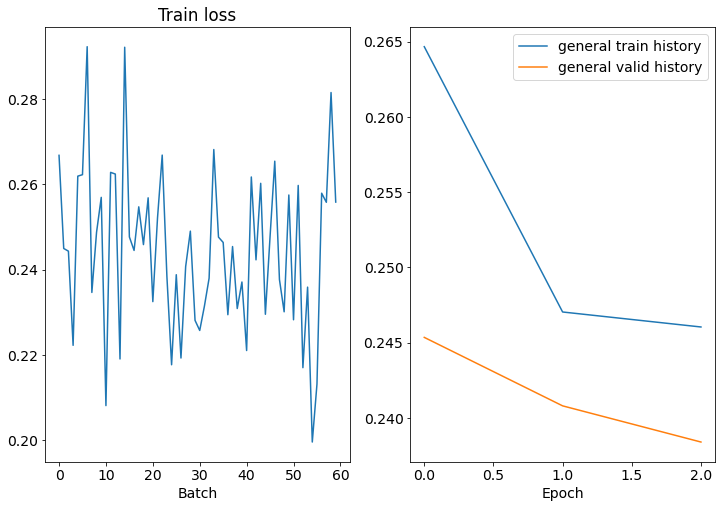

Epoch: 04 | Time: 0m 17s
	Train Loss: 0.245 | Train PPL:   1.277
	 Val. Loss: 0.240 |  Val. PPL:   1.271

Top-k inference results: 

Count: 256
Ref: в брюсселе завершились консультации россии , ес и украины по транзиту газа . перед этим по данному вопросу провели телефонные переговоры президент россии владимир путин и канцлер фрг ангелой меркель . соглашение заканчивается в конце года , и новое далеко от подписания . отказ « газпрома » от прокачки поставляемого в евросоюз газа через украину будет стоить киеву $ 3 млрд ежегодно .
Hyp: в брюсселе завершились трехсторонние консультации россии , украины и евросоюза по транзиту газа . главным вопросом в повестке стала судьба договора о транзите российского газа через украину . текущее соглашение истекает в конце нынешнего года .
BLEU:  0.44854926516912624
ROUGE:  {'rouge-1': {'f': 0.31443844422137385, 'p': 0.2988537965554096, 'r': 0.3488111978182743}, 'rouge-2': {'f': 0.13662310550557208, 'p': 0.1262238076013429, 'r': 0.15902210470673978}, 

In [ ]:
model_10 = SentenceTaggerRNN(vocab_size).to(device)

N_EPOCHS = 4
CLIP = 1

general_train(model_10, False, N_EPOCHS, CLIP)
print()

model_10.load_state_dict(torch.load('best-val-model.pt'))
print('Top-k inference results: \n')
inference_summarunner(model_10, test_iterator, 3)
print()
print('Positive logits inference results: \n')
inference_summarunner_2(model_10, test_iterator)

### model_01 (-novelty +weights)

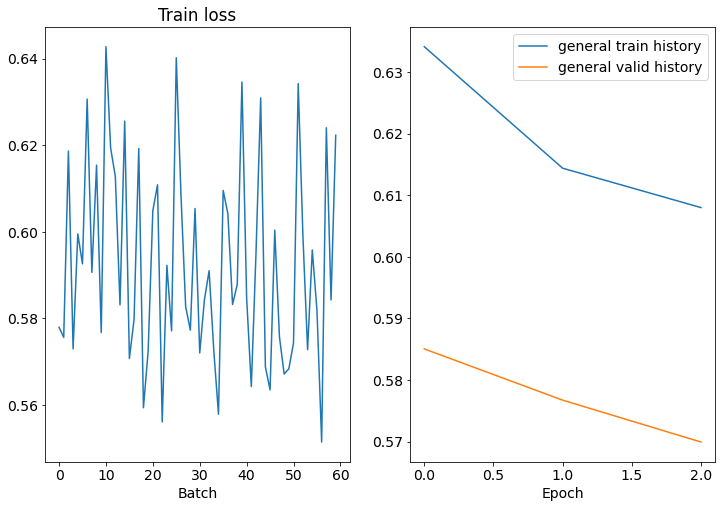

Epoch: 04 | Time: 0m 16s
	Train Loss: 0.592 | Train PPL:   1.808
	 Val. Loss: 0.570 |  Val. PPL:   1.768

Top-k inference results: 

Count: 256
Ref: адвокат сергей жорин сообщил , что рэпер алексей долматов , известный как гуф , уже прилетел в москву после остановки в оаэ . добравшись до столицы , долматов снова обратился к основателю движения « антидилер » дмитрию носову и в нецензурной форме попросил его привезти наркотики .
Hyp: рэпер алексей долматов , выступающий под псевдонимом гуф , добрался до москвы после пересадки в абу-даби . об этом корреспонденту « газеты . ru » сообщил адвокат артиста сергей жорин . « сейчас , по моей информации , он уже прилетел [ в москву ] » , — сказал жорин днем 21 января .
BLEU:  0.4456288437620585
ROUGE:  {'rouge-1': {'f': 0.3141571250883551, 'p': 0.29797297492175395, 'r': 0.34962923335357204}, 'rouge-2': {'f': 0.1366719348603308, 'p': 0.12603134356099568, 'r': 0.15963407207639863}, 'rouge-l': {'f': 0.2701432381613605, 'p': 0.26878077361837294, 'r':

In [ ]:
model_01 = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)

N_EPOCHS = 4
CLIP = 1

general_train(model_01, True, N_EPOCHS, CLIP)
print()

model_01.load_state_dict(torch.load('best-val-model.pt'))
print('Top-k inference results: \n')
inference_summarunner(model_01, test_iterator, 3)
print()
print('Positive logits inference results: \n')
inference_summarunner_2(model_01, test_iterator)

### model_00 (-novelty -weights)

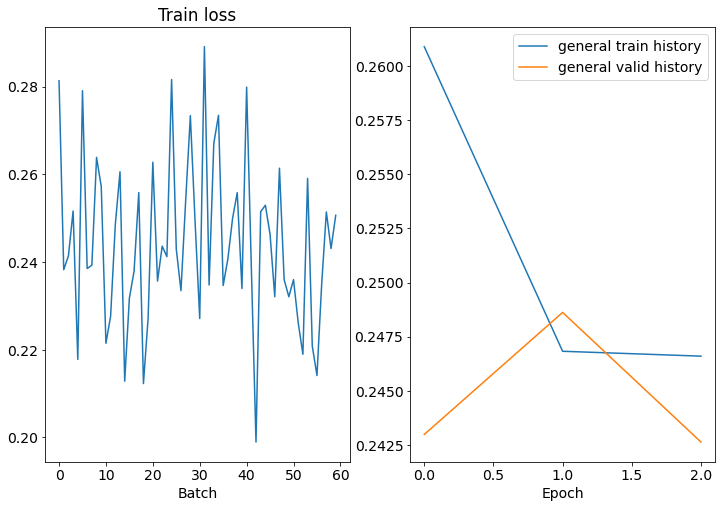

Epoch: 04 | Time: 0m 16s
	Train Loss: 0.245 | Train PPL:   1.277
	 Val. Loss: 0.240 |  Val. PPL:   1.271

Top-k inference results: 

Count: 256
Ref: россиянка алена косторная установила новый мировой рекорд , выиграв короткую программу у женщин на заключительном этапе гран-при . другая ученица этери тутберидзе алина загитова не смогла составить конкуренцию лидерам , совершив несколько грубых ошибок . хореограф илья авербух допустил , что олимпийская чемпионка угодила в « психологическую яму » , а косторная , по его мнению , откаталась идеально , сделав себя одной из главных претенденток на победу в чемпионате мира .
Hyp: в японском саппоро стартовал заключительный этап гран-при по фигурному катанию . традиционно наибольший интерес у зрителей вызвали выступления женщин-одиночниц , среди которых выступили в том числе и олимпийская чемпионка алина загитова , а также еще одна одаренная россиянка алена косторная . главной оппоненткой россиянок же , как и предполагалось , стала местная фигур

In [ ]:
model_00 = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)

N_EPOCHS = 4
CLIP = 1

general_train(model_00, False, N_EPOCHS, CLIP)
print()

model_00.load_state_dict(torch.load('best-val-model.pt'))
print('Top-k inference results: \n')
inference_summarunner(model_00, test_iterator, 3)
print()
print('Positive logits inference results: \n')
inference_summarunner_2(model_00, test_iterator)

## Вывод:

Прим.: в следующей таблице для краткости будут приведены показатели ROUGE-1 (f) и ROUGE-2 (f) каждой из моделей, которые представляют собой подобие f1-score на униграммах и биграммах соответственно. Чтобы посмотреть precision — ROUGE-N (p), recall — ROUGE-N (r) или величину ROUGE по самой длинной подпоследовательности — ROUGE-L, следует обратиться непосредственно к выходам функций inference для каждой из моделей.

In [ ]:
data = {'model_00': {('Novelty',''): 'False', ('Weights',''): 'False', ('BLEU','top-3'): 0.4485, 
                     ('BLEU','positive logits'): 0.0792, ('ROUGE-1 f','top-3'): 0.3144, 
                     ('ROUGE-1 f','positive logits'): 0.1987, ('ROUGE-2 f','top-3'): 0.1366, 
                     ('ROUGE-2 f','positive logits'): 0.0991},
        
        'model_01': {('Novelty',''): 'False', ('Weights',''): 'True', ('BLEU','top-3'): 0.4456, 
                     ('BLEU','positive logits'): 0.2773, ('ROUGE-1 f','top-3'): 0.3142, 
                     ('ROUGE-1 f','positive logits'): 0.2849, ('ROUGE-2 f','top-3'): 0.1367, 
                     ('ROUGE-2 f','positive logits'): 0.1188},
        
        'model_10': {('Novelty',''): 'True', ('Weights',''): 'False', ('BLEU','top-3'): 0.4485, 
                     ('BLEU','positive logits'): 0, ('ROUGE-1 f','top-3'): 0.3144, 
                     ('ROUGE-1 f','positive logits'): 0, ('ROUGE-2 f','top-3'): 0.1366, 
                     ('ROUGE-2 f','positive logits'): 0},
        
        'model_11': {('Novelty',''): 'True', ('Weights',''): 'True', ('BLEU','top-3'): 0.4485, 
                     ('BLEU','positive logits'): 0.3072, ('ROUGE-1 f','top-3'): 0.3144, 
                     ('ROUGE-1 f','positive logits'): 0.2968, ('ROUGE-2 f','top-3'): 0.1366, 
                     ('ROUGE-2 f','positive logits'): 0.1267}}

results = pd.DataFrame(data, index=data['model_00'].keys())
results

model_00 model_01 model_10 model_11
Novelty                      False    False     True     True
Weights                      False     True    False     True
BLEU      top-3             0.4485   0.4456   0.4485   0.4485
          positive logits   0.0792   0.2773        0   0.3072
ROUGE-1 f top-3             0.3144   0.3142   0.3144   0.3144
          positive logits   0.1987   0.2849        0   0.2968
ROUGE-2 f top-3             0.1366   0.1367   0.1366   0.1366
          positive logits   0.0991   0.1188        0   0.1267

Подводя итог, прежду всего нужно отметить, что в проведённых экспериментах результаты получались очень нестабильными — показатели BLEU и ROUGE каждой из моделей сильно колебались при использовании разных выборок из тренировочной, валидационной и тестовой частей исходного датасета. Даже при обучении на одной и той же выборке результаты не были детерминированы, и могли получаться разными при повторной инициализации и тренировке модели.

Переходя непосредственно к финальным результатам, приведённым в таблице, можно заметить, что при выборе в inference топ-3 предложений по вероятности включения в summary, все модели продемонстрировали практически одинаковое качество по всем метрикам. Показатели немного отличаются только у model_01, но, учитывая наблюдавшуюся нестабильность результатов, я думаю, что эти отличия несущественны. Исходя из этого можно заключить, что по меньшей мере 3 предложения с самыми высокими вероятностями попадания в summary "примерно" (из-за нестабильности) совпадали для всех моделей, независимо от абсолютных значений выдаваемых ими вероятностей. Более никаких явных паттернов в поведении моделей при данном подходе я не обнаружил.

Гораздо более интересная картина наблюдается при выборе в inference только положительных логитов. В данном случае прослеживается одна и та же закономерность в результатах по всем метрикам: лучшее качество показывает model_11, чуть отстаёт от неё model_01, показатели model_00 уже заметно более низкие, а качество model_10 вообще нулевое. Получается, что в проведённых экспериментах использование весов напрямую коррелировало с качеством модели. Возможно, косвенным подтверждением этому также являются нулевые показатели model_10 по всем метрикам — такое было возможно только в том случае, если модель не предсказывала вообще ничего (summary были пустыми), т.е. логиты всех предложений были отрицательными. Иными словами, модель предсказывала класс 0 (представителей которого было гораздо больше, чем представителей класса 1) для всех предложений. И если такой результат действительно обусловливается отсутствием весов, то очень низкое качество model_00 (в сравнении с model_01 и model_11) вполне может объясняться тем же эффектом. Ещё одна деталь, которую стоит отметить при сравнении разных подходов к обучению (с весами и без них) — модели, обучавшиеся без весов, демонстрировали куда более низкий лосс. Возможно, это вновь-таки связано с тем, что они чаще предсказывали 0 и, ввиду равенства весов в их лоссе и дисбаланса классов, как будто ошибались значительно реже. Этот же факт говорит об отсутствии связи между абсолютной величиной лосса и качеством модели (более низкий лосс не означает более высокое качество). Влияние же novelty однозначно определить не получается — среди моделей, которые обучались с весами, лучшее (с небольшим отрывом) качество показала та, где применялась novelty, а среди моделей, обучавшихся без весов — модель без novelty.

В целом же показатели моделей при отборе положительных логитов получились куда более низкими и неоднородными, чем при ранжировании логитов. Кроме того, можно заметить, что в результатах model_01 и model_11 BLEU при смене функции инференса меняется куда сильнее, нежели ROUGE (f). Возможно, это связано с "природой" данных метрик и тем, как менялись предсказанные summary при смене подхода к inference. Посмотрев на вывод функции инференса (а конкретно — на выводимые oracle summary и предсказанное summary), можно заметить, что на конкретных примерах model_01 и model_11 при фильтрации логитов (logits > 0) захватили гораздо больше предложений, чем было в oracle summary. Если предположить, что такое же поведение они демонстрировали и на остальных текстах, то кажется возможным, что из-за этого доля правильно предсказанных предложений уменьшилась, и BLEU, представляющая собой аналог precision, упала. При этом "покрытие" правильных предложений (recall), наоборот должно было как минимум не ухудшиться, т.к. топ-3 предложений в него, очевидным образом, снова попадал, но также включались и другие предложения, которых ранее не было в summary из-за взятия только предложений с наибольшей вероятностью. Таким образом, получаем, что ROUGE (f), являющаяся аналогом f1-score, изменилась бы не так сильно, как BLEU — что мы и можем наблюдать. С model_00 и model_10 ситуация в некотором роде обратная — на выведенных после инференса примерах видно, что данные модели не добавили в их summary ни одного предложения, а model_10 при этом, скорее всего, выдала пустые summary вообще на всех текстах. И, поскольку в предсказаниях (почти) ничего не было, и BLEU, и ROUGE упали гораздо сильнее, чем у model_01 и model_11.

Таким образом, по результатам проведённых экспериментов можно сделать следующие выводы: 

1. При обучении следует задавать веса классов, их наличие напрямую коррелирует с качеством — иначе модель может начать предсказывать очень короткие / пустые summary
2. Выбор top-k предложений для summary — более универсальный метод, нежели фильтр логитов, поскольку позволяет получать неплохое (а в данных экспериментах — примерно одинаковое) качество для разных моделей, независимо от выдаваемых ими значений вероятностей. Фильтр логитов же может привести либо к слишком большому, либо к слишком маленькому summary.
3. Влияние novelty оценить сложно, поскольку какой-либо односторонней связи между его использованием и качеством не наблюдалось

